# Data Preprocessing for Financial Sentiment Analysis

This notebook handles the **loading, cleaning, standardization, and splitting** of multiple financial sentiment datasets to create a unified dataset for benchmarking.

We will:

-   Load datasets from HuggingFace and local files
-   Normalize labels and text columns
-   Clean the text using a reusable cleaning function
-   Split into training and validation sets
-   Export for reuse in downstream notebooks


In [22]:
# Import libraries

import re
import sys

sys.path.append("../scripts")

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datasets import load_dataset
from IPython.display import display, display_markdown
from preprocessing import clean_text
from sklearn.model_selection import train_test_split

c:\Users\Sid\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Datasets

We will work with four datasets:

1. **Twitter Financial News** — Real-world Twitter sentiment around finance.
2. **Financial PhraseBank (FPB)** — Annotated financial sentences.
3. **FiQA 2018** — Sentence-level sentiment in financial Q&A and news. (961 rows)


In [ ]:
# Twitter Financial News
twitter_train = pd.read_csv(
    "hf://datasets/zeroshot/twitter-financial-news-sentiment/sent_train.csv"
)
twitter_val = pd.read_csv(
    "hf://datasets/zeroshot/twitter-financial-news-sentiment/sent_valid.csv"
)
twitter = pd.concat([twitter_train, twitter_val], ignore_index=True)

# Financial PhraseBank
fpb = pd.DataFrame(
    load_dataset("takala/financial_phrasebank", "sentences_50agree")[
        "train"
    ]  # >=50% agreement on sentiment
)

# FiQA
fiqa_ds = load_dataset("pauri32/fiqa-2018")
fiqa = pd.concat(
    [
        pd.DataFrame(fiqa_ds["train"]),
        pd.DataFrame(fiqa_ds["validation"]),
        pd.DataFrame(fiqa_ds["test"]),
    ],
    ignore_index=True,
)

# Store the raw datasets in CSV format
twitter.to_csv("../data/raw/twitter_financial_news.csv", index=False)
fpb.to_csv("../data/raw/financial_phrasebank.csv", index=False)
fiqa.to_csv("../data/raw/fiqa_2018.csv", index=False)

## Visualizing the Datasets


In [24]:
display_markdown("##### Twitter Dataset", raw=True)
display(twitter.head())

display_markdown("##### Financial PhraseBank Dataset", raw=True)
display(fpb.head())

display_markdown("##### FiQa 2018 Dataset", raw=True)
display(fiqa.head())

##### Twitter Dataset

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


##### Financial PhraseBank Dataset

,sentence,label
0,"According to Gran , the company has no plans t...",1
1,Technopolis plans to develop in stages an area...,1
2,The international electronic industry company ...,0
3,With the new production plant the company woul...,2
4,According to the company 's updated strategy f...,2


##### FiQa 2018 Dataset

,sentence,snippets,target,sentiment_score,aspects,format,label
0,Still short $LNG from $11.70 area...next stop ...,['Still short $LNG from $11.70 area...next sto...,LNG,-0.543,['Stock/Price Action/Volatility/Short Selling'],post,2
1,$PLUG bear raid,['bear raid'],PLUG,-0.480,['Stock/Price Action/Bearish'],post,2
2,How Kraft-Heinz Merger Came Together in Speedy...,['Merger Came Together in Speedy 10 Weeks'],Kraft,0.214,['Corporate/M&A/M&A'],headline,0
3,Slump in Weir leads FTSE down from record high,['down from record high'],Weir,-0.827,['Market/Volatility/Volatility'],headline,2
4,"$AAPL bounces off support, it seems",['bounces off support'],AAPL,0.443,['Stock/Price Action/Bullish/Bullish Behavior'],post,0


In [25]:
print(f"Twitter shape: {twitter.shape}")
print(f"FPB shape: {fpb.shape}")
print(f"FiQA shape: {fiqa.shape}")

Twitter shape: (11931, 2)
FPB shape: (4846, 2)
FiQA shape: (1213, 7)


## Basic Cleaning

We will:

-   Normalize text columns to `sentence`
-   Standardize labels across datasets
-   Remove duplicates


In [26]:
# Check for missing values

print(twitter.isna().sum(), "\n")
print(fpb.isna().sum(), "\n")
print(fiqa.isna().sum())

text     0
label    0
dtype: int64 

sentence    0
label       0
dtype: int64 

sentence           0
snippets           0
target             0
sentiment_score    0
aspects            0
format             0
label              0
dtype: int64


In [27]:
# Normalize labels
twitter.replace({0: "negative", 1: "positive", 2: "neutral"}, inplace=True)
fpb.replace({0: "negative", 1: "neutral", 2: "positive"}, inplace=True)
fiqa.replace({0: "positive", 1: "neutral", 2: "negative"}, inplace=True)

# Rename + tag sources
twitter.rename(columns={"text": "sentence"}, inplace=True)
twitter["source"] = "Twitter"
fpb["source"] = "FPB"
fiqa["source"] = "FiQA"

# Drop unused columns from FiQA
fiqa.drop(
    columns=["snippets", "target", "sentiment_score", "aspects", "format"],
    errors="ignore",
    inplace=True,
)

pd.set_option("display.max_colwidth", None)

print("Column normalization complete")
display_markdown("Twitter example", raw=True)
display(twitter.head(1))
display_markdown("FPB example", raw=True)
display(fpb.head(1))
display_markdown("FiQA example", raw=True)
display(fiqa.head(1))

Column normalization complete


Twitter example

,sentence,label,source
0,$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT,negative,Twitter


FPB example

,sentence,label,source
0,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .",neutral,FPB


FiQA example

,sentence,label,source
0,"Still short $LNG from $11.70 area...next stop could be down through $9.00. Someone slammed it hard with 230,000 shs this am! More to follow",negative,FiQA


#### Remove Duplicates


In [28]:
print("Dropping duplicates...")

before = twitter.shape[0]
twitter.drop_duplicates(subset="sentence", inplace=True)
print(f"Twitter duplicates removed: {before - twitter.shape[0]}")

before = fpb.shape[0]
fpb.drop_duplicates(subset="sentence", inplace=True)
print(f"FPB duplicates removed: {before - fpb.shape[0]}")

before = fiqa.shape[0]
fiqa.drop_duplicates(subset="sentence", inplace=True)
print(f"FiQA duplicates removed: {before - fiqa.shape[0]}")

Dropping duplicates...
Twitter duplicates removed: 0
FPB duplicates removed: 8
FiQA duplicates removed: 102


#### Clean Text

We apply cleaning to:

-   Remove URLs and non-alphanumerics
-   Normalize spacing

The function is defined below:


In [45]:
print("Cleaning text...")

twitter["sentence"] = twitter["sentence"].apply(clean_text)
fpb["sentence"] = fpb["sentence"].apply(clean_text)
fiqa["sentence"] = fiqa["sentence"].apply(clean_text)

print("Sample cleaned sentence:")
print(twitter.sample(1)["sentence"].values[0])

Cleaning text...
Sample cleaned sentence:
Netflix is spending 420 million to produce more local content in India CEO Reed Hastings says


In [30]:
import pandas as pd

all_data = pd.read_csv("../data/processed/data.csv")

all_data["sentence"] = all_data["sentence"].astype(str)
all_data["word_count"] = all_data["sentence"].apply(
    lambda x: len(x.split(" "))
)  # Count words in each sentence
all_data[all_data["word_count"] < 4].shape

(166, 4)

## Combine Datasets & Check Distribution


In [31]:
all_data = pd.concat([twitter, fpb, fiqa], ignore_index=True)

print(f"Combined dataset shape: {all_data.shape}")
print("\nLabel distribution:")
print((all_data["label"].value_counts(normalize=True) * 100).round(1).astype(str) + "%")
print("\nSource distribution:")
print(all_data["source"].value_counts())

Combined dataset shape: (17880, 3)

Label distribution:
label
neutral     59.8%
positive    24.8%
negative    15.3%
Name: proportion, dtype: object

Source distribution:
source
Twitter    11931
FPB         4838
FiQA        1111
Name: count, dtype: int64


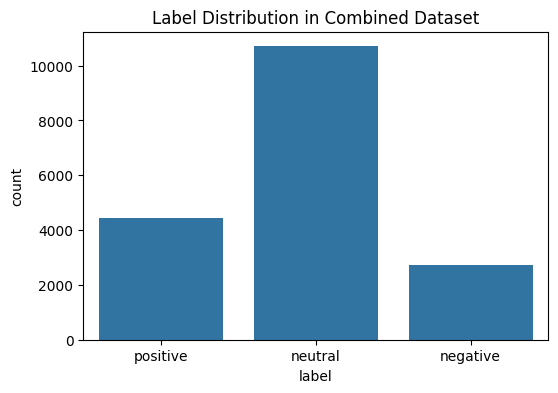

In [32]:
plt.figure(figsize=(6, 4))
sns.countplot(data=all_data, x="label", order=["positive", "neutral", "negative"])
plt.title("Label Distribution in Combined Dataset")
plt.show()

### Remove sentences with less than 3 words


In [33]:
all_data = all_data.astype(str)
word_counts = all_data["sentence"].str.split().apply(len)
print(all_data[word_counts < 3].shape[0])
all_data = all_data[word_counts >= 3]
print(all_data.shape)

77
(17803, 3)


## Train/Validation Split

We stratify by label to preserve class balance.


In [34]:
train_df, val_df = train_test_split(
    all_data, test_size=0.1, stratify=all_data["label"], random_state=42
)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")

print(
    "\nTrain label distribution:\n",
    train_df["label"].value_counts(normalize=True).round(3),
)
print(
    "\nValidation label distribution:\n",
    val_df["label"].value_counts(normalize=True).round(3),
)

Train size: 16022
Validation size: 1781

Train label distribution:
 label
neutral     0.597
positive    0.249
negative    0.154
Name: proportion, dtype: float64

Validation label distribution:
 label
neutral     0.597
positive    0.249
negative    0.154
Name: proportion, dtype: float64


In [ ]:
# Save processed datasets
train_df.to_csv("../data/processed/train.csv", index=False)
val_df.to_csv("../data/processed/val.csv", index=False)
all_data.to_csv("../data/processed/data.csv", index=False)

## Summary

-   Loaded 3 datasets (Twitter, FPB, FiQA)
-   Cleaned and standardized sentence + label columns
-   Removed 110 duplicates across sources
-   Cleaned sentence text for modeling
-   Created stratified train/val split
-   Saved processed files for downstream model training

Next: Open **[2_logistic_regression.ipynb](2_logistic_regression.ipynb)** to benchmark a classical model!
